In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports 
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as tf
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Internal imports
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys; sys.path.insert(0, '..')
from src import *

In [3]:
NUM_INPUT_CHANNELS = 1 # 1 for grayscale, 3 for RGB
NUM_CHARS = 4 # number of characters in each image
NUM_CLASSES = 600 
N_DIMS=1 # output dimension
BS = 512 # batch size
NUM_EPOCHS = 2000 
SEED = 50
LR = 1e-4
DROPOUT = 0.20
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# ALPHAS = [0, 0.1, 0.2, 0.4, 0.5, 0.75, 1.0]
ALPHAS = get_dim_mix_masks((1, 56, 56)) # masks distributions: size = (1, 28 * sqrt(num_chars), 28 * sqrt(num_chars))

n_img 2


In [4]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)


In [5]:
# Define model
model = RatioCriticImageBilinear(dim_input=N_DIMS, dim_output=1, num_input_channels=1, num_classes=NUM_CLASSES, dropout=DROPOUT, alphas=ALPHAS, use_scale_shift=True)
model.apply(weights_init)

# Try larger MLP (final layer) sizes

# Run a sample to initialize ScaleShift layers
with torch.no_grad():
    t = torch.randn(32,1,56,56)
    model(t, t, t, t)

# Define optimizer
optim = torch.optim.Adam(model.parameters(), lr=LR)

# Define LR scheduler (cosine annealing)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 50000 // BS * NUM_EPOCHS, verbose=True)

Alphas set to tensor([[[[[0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
     

In [6]:
# Define transforms
transforms = None # tf.Compose([tf.ToTensor()])

# Define dataset & dataloader
train_ds1 = SpatialOmniDataset('../data/omniglot/multiomniglot_trn_{}.npz'.format(NUM_CHARS), transforms=transforms)
train_ds2 = SpatialOmniDataset('../data/omniglot/multiomniglot_trn_{}.npz'.format(NUM_CHARS), transforms=transforms)
train_ds = PairedSpatialOmniDataset(train_ds1, train_ds2)

val_ds1 = SpatialOmniDataset('../data/omniglot/multiomniglot_val_{}.npz'.format(NUM_CHARS), transforms=transforms)
val_ds2 = SpatialOmniDataset('../data/omniglot/multiomniglot_val_{}.npz'.format(NUM_CHARS), transforms=transforms)
val_ds = PairedSpatialOmniDataset(val_ds1, val_ds2)

test_ds1 = SpatialOmniDataset('../data/omniglot/multiomniglot_tst_{}.npz'.format(NUM_CHARS), transforms=transforms)
test_ds2 = SpatialOmniDataset('../data/omniglot/multiomniglot_tst_{}.npz'.format(NUM_CHARS), transforms=transforms)
test_ds = PairedSpatialOmniDataset(test_ds1, test_ds2)

In [8]:
# Define dataloader
def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True, worker_init_fn=worker_init_fn)
test_dl = DataLoader(test_ds, batch_size=BS, shuffle=False, worker_init_fn=worker_init_fn)

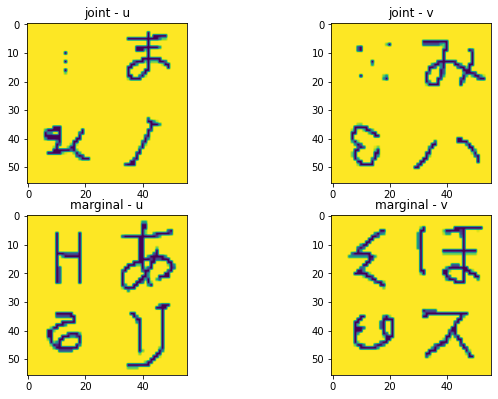

In [9]:
# Visualize joint, m, marginal images
with torch.no_grad():
    for (u, v, l1), (u_q, v_q, l2) in iter(train_dl):
#         if torch.cuda.is_available():
#             u, v = u.to(DEVICE), v.to(DEVICE)
        
        i = 11
        plt.figure(1, figsize=(10,10))
        plt.subplot(321)
        plt.title('joint - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))

        plt.subplot(322)
        plt.title('joint - v')
        plt.imshow(v[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(323)
        plt.title('marginal - u')
        plt.imshow(u_q[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(324)
        plt.title('marginal - v')
        plt.imshow(v_q[torch.randperm(len(v_q))][i].cpu().numpy().transpose(1,2,0))
        
#         v_m = model.test_forward(u,v)
        
#         plt.subplot(325)
#         plt.title('m - u')
#         plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
#         plt.subplot(326)
#         plt.title('m - v')
#         plt.imshow(v_m[i].cpu().numpy().transpose(1,2,0))
        
        break

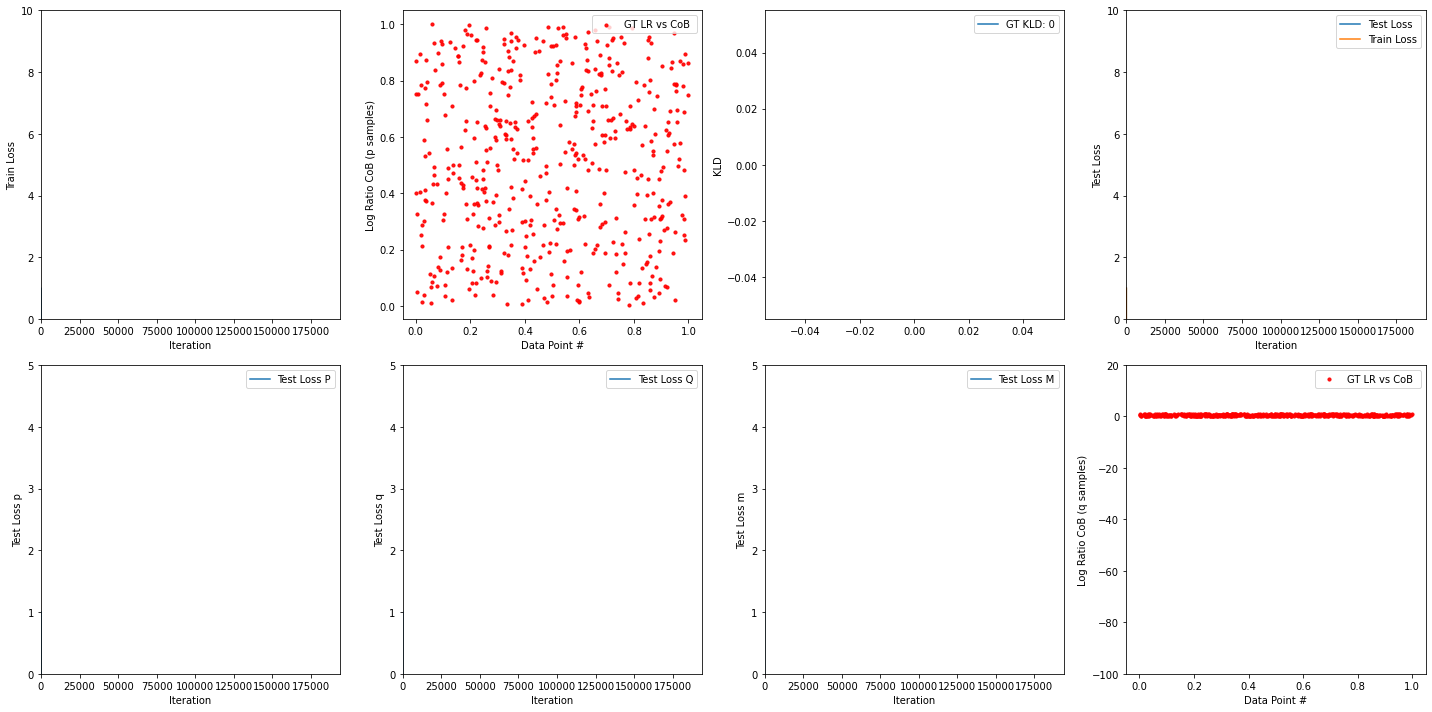

In [10]:
# Set up viz
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2, 4,figsize=(20,10))

line, = ax1.plot([0,1],[0,1])
test_line, = ax4.plot([0,1],[0,1],label='Test Loss')
test_line1, = ax4.plot([0,1],[0,1],label='Train Loss')

test_line_p, = ax5.plot([0,1],[0,1],label='Test Loss P')
test_line_q, = ax6.plot([0,1],[0,1],label='Test Loss Q')
test_line_m, = ax7.plot([0,1],[0,1],label='Test Loss M')

kld_line, = ax3.plot([0],[0],label='GT KLD: '+str(0))
x, y = np.random.random((2, 500))

scat = ax2.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')
scat8 = ax8.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax1.set_ylim([0,10])

# ax2.set_xlabel("Data Point")
ax2.set_ylabel("Log Ratio CoB (p samples)")
ax2.set_xlabel("Data Point #")
ax2.legend(loc='best')

ax3.set_ylabel("KLD")
ax3.legend(loc='best')

ax4.set_xlabel("Iteration")
ax4.set_ylabel("Test Loss")
ax4.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax4.set_ylim([0,10])
ax4.legend(loc='best')

ax5.set_xlabel("Iteration")
ax5.set_ylabel("Test Loss p")
ax5.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax5.set_ylim([0,5])
ax5.legend(loc='best')

ax6.set_xlabel("Iteration")
ax6.set_ylabel("Test Loss q")
ax6.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax6.set_ylim([0,5])
ax6.legend(loc='best')

ax7.set_xlabel("Iteration")
ax7.set_ylabel("Test Loss m")
ax7.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax7.set_ylim([0,5])
ax7.legend(loc='best')

ax8.set_ylabel("Log Ratio CoB (q samples)")
ax8.set_xlabel("Data Point #")
ax8.legend(loc='best')
ax8.set_ylim([-100, 20])



plt.tight_layout()

loss_store = []
kld_store = []
test_loss_store = []
test_loss_store1 = []
test_loss_store_p = []
test_loss_store_q = []
test_loss_store_m = []

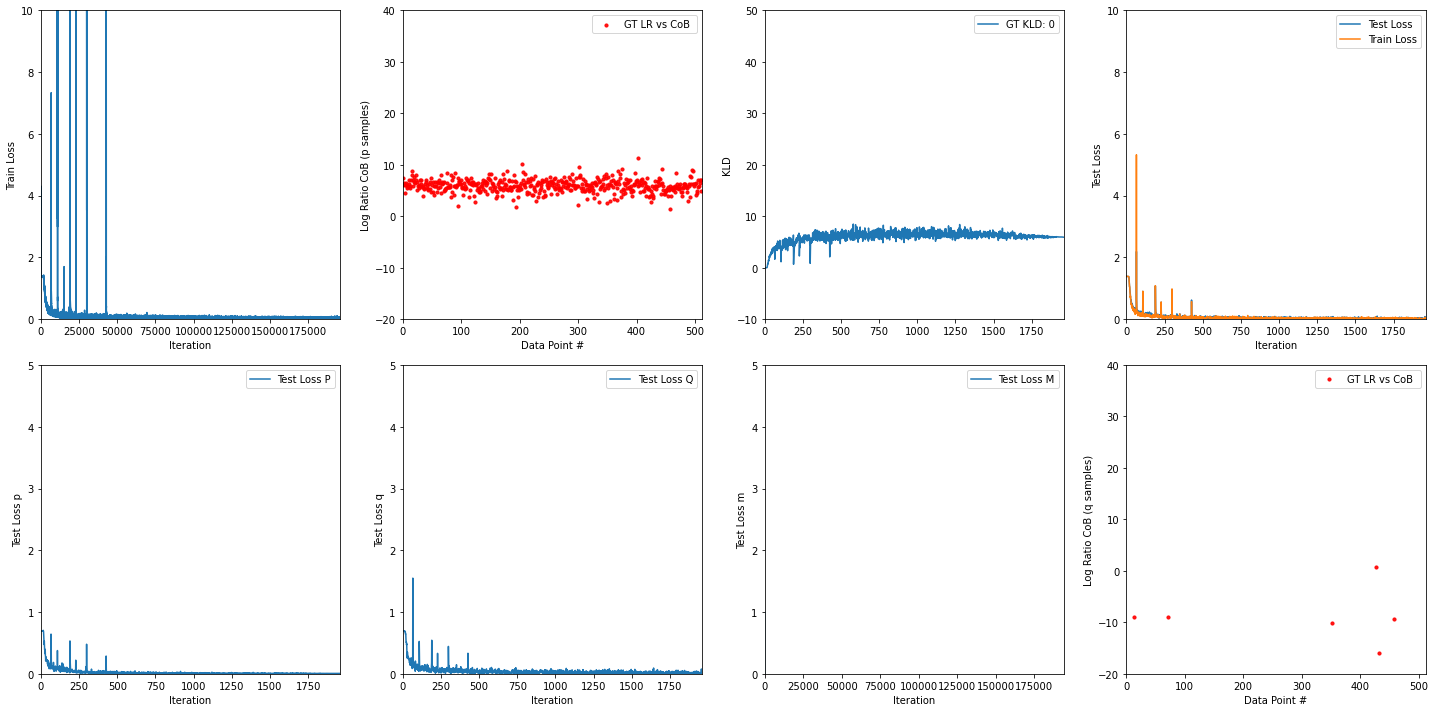

100%|██████████| 2000/2000 [26:35:55<00:00, 47.88s/it]

Estimated KL: 5.933737754821777
Estimated KL:  -5.933737754821777


In [11]:
model.train()

if torch.cuda.is_available():
    model = model.to(DEVICE)
    
i = 0
loss_crit = torch.nn.BCELoss()
sig = torch.nn.Sigmoid()
# loss_crit = torch.nn.CrossEntropyLoss()

for epoch in trange(NUM_EPOCHS):
    for (u, v, _), (u_q, v_q, _) in iter(train_dl):
        model.train()
        i += 1
        
        optim.zero_grad()
        
        # CUDA
        if torch.cuda.is_available():
            u, v, u_q, v_q = u.to(DEVICE), v.to(DEVICE), u_q.to(DEVICE), v_q.to(DEVICE)
            
        v_q = v_q[torch.randperm(len(v_q))]
        
        logP, logQ = model(u, v, u_q, v_q)
        logP, logQ = sig(logP.squeeze()), sig(logQ.squeeze())
        
        p_label = torch.empty(u.shape[0], dtype=torch.float32, device=DEVICE).fill_(0)
        q_label = torch.empty(u.shape[0], dtype=torch.float32, device=DEVICE).fill_(1)
#         m_label = torch.empty(u.shape[0], dtype=torch.long, device=DEVICE).fill_(2)
        
        loss = loss_crit(logP, p_label) + loss_crit(logQ, q_label)
        loss.backward()
        optim.step()
        loss_store.append(loss.item())
        scheduler.step()
        # Validation/Test
        if i % 100 == 0:
            model.eval()
            
            with torch.no_grad():
                for (u, v, _), (u_q, v_q, _) in iter(test_dl):
#                     log_ratio_p_q, _ = get_gt_ratio_kl(p, q, m_batch)
#                     _, kl_from_p_q = get_gt_ratio_kl(p, q, p_batch)
    
                    if torch.cuda.is_available():
#                         u, v, u_q, v_q = u.to(DEVICE), v.to(DEVICE), u_q.to(DEVICE), v_q.to(DEVICE)
                        u, v, u_q, v_q = u.to(DEVICE), v.to(DEVICE), u_q.to(DEVICE), v_q.to(DEVICE)
                
                    # Shuffling v_q
                    v_q = v_q[torch.randperm(len(v_q))]
                    logP, logQ = model(u, v, u_q, v_q)
                    kl_est = logP.mean().item()

                    logP, logQ = sig(logP.squeeze()), sig(logQ.squeeze())

                    log_ratio_p_q_from_cob_p = -1.0 * torch.log(logP / (1-logP))
                    kl_from_cob = torch.mean(log_ratio_p_q_from_cob_p)
                    
                    log_ratio_p_q_from_cob_q = -1.0 * torch.log(logQ / (1-logQ))

                    p_label = torch.empty(u.shape[0], dtype=torch.float32, device=DEVICE).fill_(0)
                    q_label = torch.empty(u.shape[0], dtype=torch.float32, device=DEVICE).fill_(1)
                    
                    test_loss = loss_crit(logP, p_label) + loss_crit(logQ, q_label)

                    # Visualize
                    # First plot of loss
                    line.set_data(range(len(loss_store)), loss_store)
                    ax1.set_xlim( 0, len(loss_store))

                    kld_store.append(kl_from_cob.cpu().detach().numpy())
                    test_loss_store.append(test_loss.item())
                    test_loss_store1.append(loss.item())
                    
                    test_loss_store_p.append(loss_crit(logP, p_label).item())
                    test_loss_store_q.append(loss_crit(logQ, q_label).item())
#                     test_loss_store_m.append(loss_crit(logM, m_label).item())

                    scat.set_offsets(np.vstack([range(len(log_ratio_p_q_from_cob_p)),log_ratio_p_q_from_cob_p.cpu().detach().numpy()]).T)
                    ax2.set_xlim(0, len(log_ratio_p_q_from_cob_p))
                    ax2.set_ylim(-20, 40)
                    
                    scat8.set_offsets(np.vstack([range(len(log_ratio_p_q_from_cob_q)),log_ratio_p_q_from_cob_q.cpu().detach().numpy()]).T)
                    ax8.set_xlim(0, len(log_ratio_p_q_from_cob_q))
                    ax8.set_ylim(-20, 40)

                    kld_line.set_data(range(len(kld_store)),kld_store)
                    ax3.set_xlim( 0, len(kld_store))
                    ax3.set_ylim( -10, 50)

                    test_line.set_data(range(len(test_loss_store)), test_loss_store)
                    test_line1.set_data(range(len(test_loss_store1)), test_loss_store1)
                    ax4.set_xlim( 0, len(test_loss_store) )
                    

                    test_line_p.set_data(range(len(test_loss_store_p)), test_loss_store_p)
                    ax5.set_xlim( 0, len(test_loss_store_p) )
                    
                    test_line_q.set_data(range(len(test_loss_store_q)), test_loss_store_q)
                    ax6.set_xlim( 0, len(test_loss_store_q) )
                    
#                     test_line_m.set_data(range(len(test_loss_store_m)), test_loss_store_m)
#                     ax7.set_xlim( 0, len(test_loss_store_m) )
                    
                    clear_output(wait=True)
                    display(fig)
                    print('Estimated KL: {}'.format(kl_from_cob.cpu().detach()))
                    print('Estimated KL: ', kl_est)
                    break

            model.train()
    
#     scheduler.step()